In [480]:
import pandas as pd
import numpy as np 
from hmmlearn import hmm

MAX_STATES = 6 + 1
df = pd.read_csv('energydata_complete.csv')

# Data analysis and split

* We remove the last hour of the entire dataset to have a divisible number of hours.
$$ 
    \frac{\textrm{\# samples} - 7}{144} = 137 Days
$$ = 137 days where 144 is the number of observations in a day. 
* We then split the data into training, validation and test set. 
* We use the first 70% of the data as training set, the next 20% as validation set and the last 10% as test set.

In [481]:
(Dates, Appliances, Lights) = (df.date.to_numpy()[:-7], df.Appliances.to_numpy()[:-7], df.lights.to_numpy()[:-7])

import math

Index = {}
Appliances_X = {}
Lights_X = {}

# Last Index of data to be used for training, validation and testing
Train = math.ceil(137 * 0.7) * 144
Val = math.floor(137 * 0.2) * 144


# Train data
Appliances_X['train'] = Appliances[:Train].reshape(-1, 1)
Lights_X['train'] = Lights[:Train].reshape(-1, 1)

# Validation data
Appliances_X['validation'] = Appliances[Train:Train + Val].reshape(-1, 1)
Lights_X['validation'] = Lights[Train:Train + Val].reshape(-1, 1)

# Test data
Appliances_X['test'] = Appliances[Train + Val:].reshape(-1, 1)
Lights_X['test'] = Lights[Train + Val:].reshape(-1, 1)

# Concatenated data

In [482]:
# Concatenated Appliances and Lights
Concatenated_X = {}
Concatenated_X['train'] = np.concatenate((Appliances_X['train'], Lights_X['train']), axis=1)
Concatenated_X['validation'] = np.concatenate((Appliances_X['validation'], Lights_X['validation']), axis=1)
Concatenated_X['test'] = np.concatenate((Appliances_X['test'], Lights_X['test']), axis=1)

# Models creation and training

* For each dataset: Appliances, Lights and the concatenated one, we create a model with 2, 3 and 4 hidden states then we train it with the training set created above. 
* We then evaluate the models with the validation set and we choose the best model for each dataset, by scooring the models that have the best likelihood on the validation set.

In [483]:
import pickle, os
gHMM = {}
# Dictionary of Models: Gaussian HMM for Concatenated Appliances and Lights
gHMM['Concatenated'] = {}
# Dictionary of Models: Gaussian HMM for Appliances
gHMM['Appliances'] = {}
# Discionary of Models: Gaussian HMM for Lights
gHMM['Lights'] = {}

Recalculate = False

# Gaussian HMM models from 2 to 6 states for Appliances, Lights and thier concatenation
for kind in ['Concatenated', 'Appliances', 'Lights']:
    for i in range(2, MAX_STATES):
        bestModel = {}
        bestScore = {}
        currScore = {}
        if os.path.exists('./models/gHMM_{}_{}.pkl'.format(kind, i)) and not Recalculate:
            gHMM[kind][i] = pickle.load(open('./models/gHMM_{}_{}.pkl'.format(kind, i), 'rb'))
        else:
            for idx in range(50):
                # Gaussian HMM model with i states
                gHMM[kind][i] = hmm.GaussianHMM(n_components=i, covariance_type="diag", random_state=idx, n_iter=1000)
                
                # Fit the model with the training data and calculate the score for the validation data to select the best model
                if kind == 'Concatenated':
                    gHMM[kind][i].fit(Concatenated_X['train'].reshape(-1,1), Lengths_X['train'])
                    currScore[i] = gHMM[kind][i].score(Concatenated_X['validation'].reshape(-1,1))
                elif kind == 'Appliances':
                    gHMM[kind][i].fit(Appliances_X['train'].reshape(-1,1))
                    currScore[i] = gHMM[kind][i].score(Appliances_X['validation'].reshape(-1,1))
                elif kind == 'Lights':
                    gHMM[kind][i].fit(Lights_X['train'].reshape(-1,1))
                    currScore[i] = gHMM[kind][i].score(Lights_X['validation'].reshape(-1,1))
            
                # Select the best model (check if the score is better than the previous best score)
                if i not in bestScore or currScore[i] > bestScore[i]:
                    bestScore[i] = currScore[i]
                    bestModel[i] = gHMM[kind][i]
                
            # Save the best model for the current number of states
            gHMM[kind][i] = bestModel[i]
            with open('./models/gHMM_{}_{}.pkl'.format(kind, i), 'wb') as file:
                pickle.dump(gHMM[kind][i], file)
        print('Best Model for {} with {} states : {}'.format(kind, i, gHMM[kind][i]))

Best Model for Concatenated with 2 states : GaussianHMM(n_components=2, n_iter=1000, random_state=49)
Best Model for Concatenated with 3 states : GaussianHMM(n_components=3, n_iter=1000, random_state=45)
Best Model for Concatenated with 4 states : GaussianHMM(n_components=4, n_iter=1000, random_state=3)
Best Model for Concatenated with 5 states : GaussianHMM(n_components=5, n_iter=1000, random_state=31)
Best Model for Concatenated with 6 states : GaussianHMM(n_components=6, n_iter=1000, random_state=35)
Best Model for Appliances with 2 states : GaussianHMM(n_components=2, n_iter=1000, random_state=44)
Best Model for Appliances with 3 states : GaussianHMM(n_components=3, n_iter=1000, random_state=23)
Best Model for Appliances with 4 states : GaussianHMM(n_components=4, n_iter=1000, random_state=9)
Best Model for Appliances with 5 states : GaussianHMM(n_components=5, n_iter=1000, random_state=29)
Best Model for Appliances with 6 states : GaussianHMM(n_components=6, n_iter=1000, random_st

## Try to decode the hidden states with the viterbi algorithm 

In [484]:
# Dictionary of Sequences: Concatenated Appliances and Lights
SConcTest = {}
PConcTest = {}

# Dictionary of Sequences: Appliances
SAppTest = {}
PAppTest = {}

# Dictionary of Sequences: Lights
SLightsTest = {}
PLightsTest = {}

for i in range(2, MAX_STATES):
    PConcTest[i], SConcTest[i] = gHMM['Concatenated'][i].decode(Concatenated_X['test'], algorithm='viterbi')
    PAppTest[i], SAppTest[i] = gHMM['Appliances'][i].decode(Appliances_X['test'], algorithm='viterbi')
    PLightsTest[i], SLightsTest[i] = gHMM['Lights'][i].decode(Lights_X['test'], algorithm='viterbi')

### Plot the results

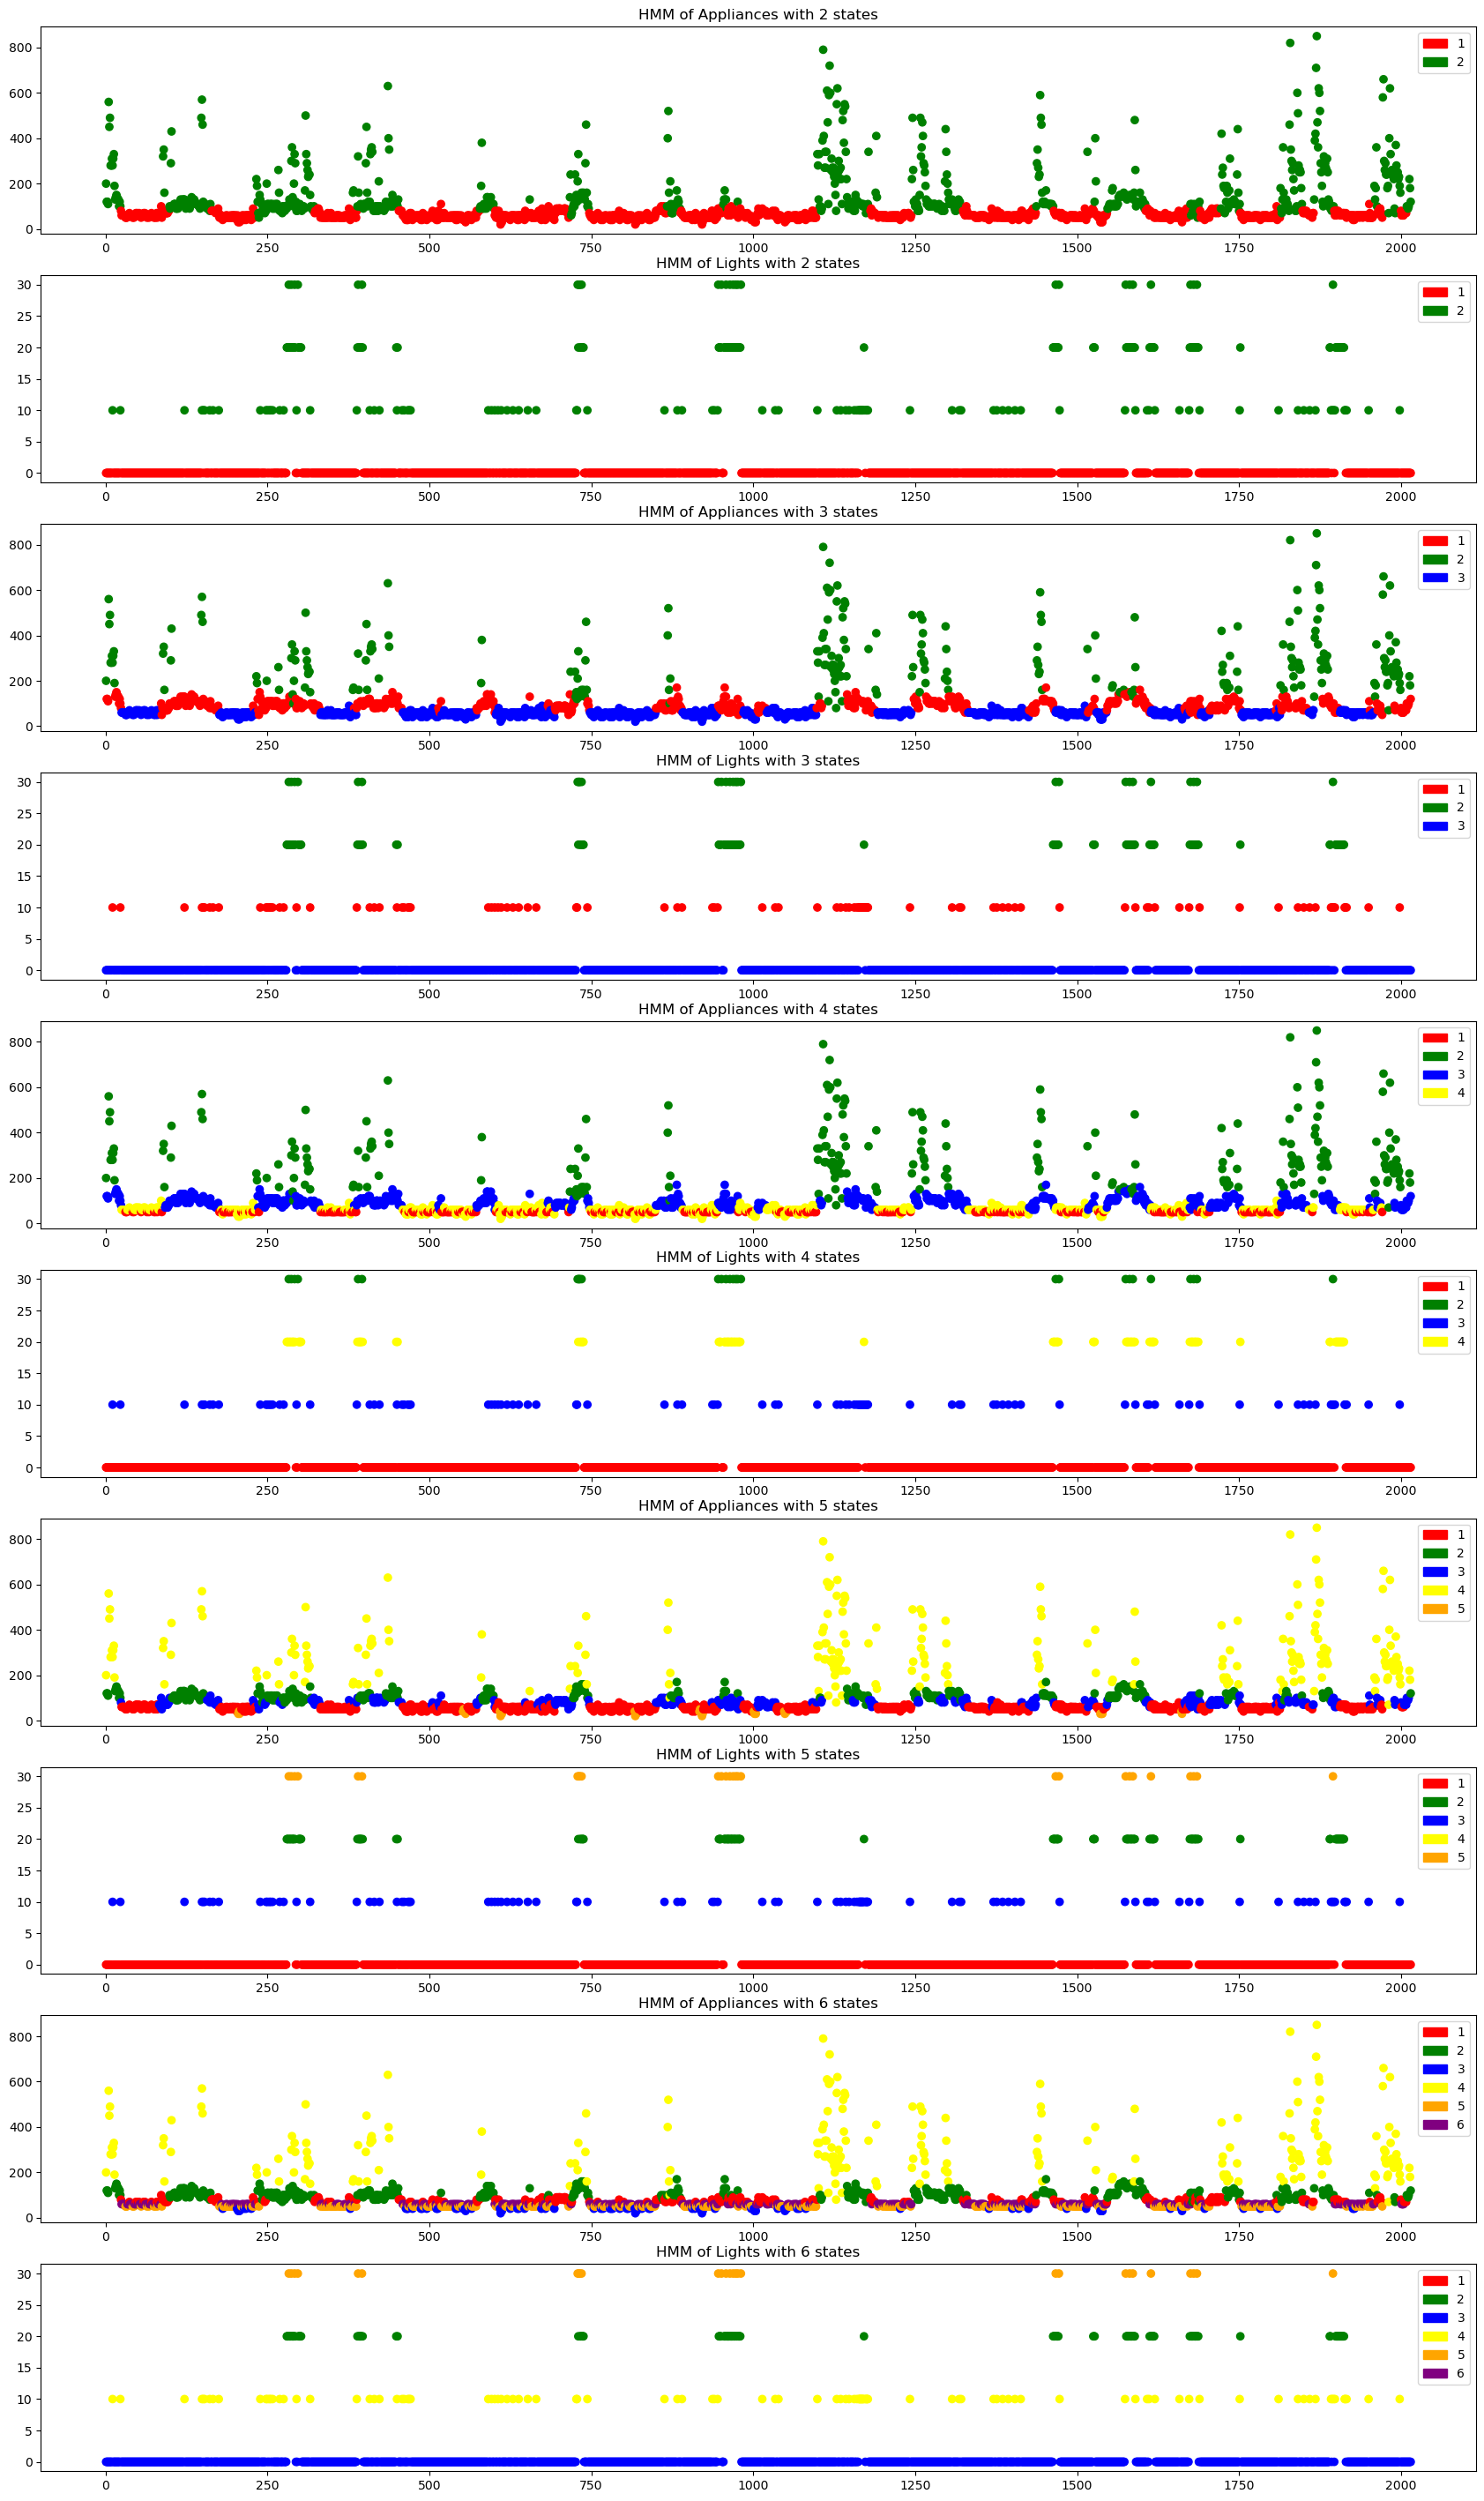

In [485]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

red_patch = {}

mapper = {1: 'red', 2: 'green', 3: 'blue', 4: 'yellow', 5: 'orange', 6: 'purple'}
red_patch = [mpatches.Patch(color=mapper[i], label=i) for i in mapper]
colorsA = {}
colorsL = {}
colorsC = {}
ax = {}

for j in range(2, MAX_STATES):
    colorsC[j] = [mapper[value+1] for value in SConcTest[j]]
    colorsA[j] = [mapper[value+1] for value in SAppTest[j]]
    colorsL[j] = [mapper[value+1] for value in SLightsTest[j]]
    
fig, ax = plt.subplots((MAX_STATES)*2 - 4, 1, figsize=(21,36))

max_range = Appliances_X['test'].shape[0]
# max_range = 100
for i in range(2, MAX_STATES):
    titleA = 'HMM of Appliances with {} states'.format(i)
    ax[(i*2) - 4].set(title=titleA)
    ax[(i*2) - 4].scatter(y=Appliances_X['test'][1:max_range], color=colorsA[i][1:max_range], x=range(1, max_range))
    ax[(i*2) - 4].legend(handles=red_patch[:i])
    
    titleL = 'HMM of Lights with {} states'.format(i)
    ax[(i*2) - 3].set(title=titleL)
    ax[(i*2) - 3].scatter(y=Lights_X['test'][1:max_range], color=colorsL[i][1:max_range], x=range(1, max_range))
    ax[(i*2) - 3].legend(handles=red_patch[:i])

## Comments on viterbi algorithm on the test set

* The viterbi algorithm shows that the hidden states are really different between the Appliances and the Lights dataset.

* On the Appliances dataset, the hidden states are not easy to distinguish as they are all very close to each other in many cases. Still it is possible to see the distribution on the timeseries when the hidden states are 3 or 2, over these values it is too confusing.

* On the Lights dataset, the hidden states are more distinguishable and we can see that the hidden states are distributed very clearly on the timeseries of the test set, but they doesn't seem to change a lot when having more than 4 states (it uses at most 4 states even if having 6 ).

* The last obeservation is that the timeseries have a sort of periodicity, which is something that we can see by looking on how the states changes over the time. Each 144 observations, the hidden states "motif" repeats. This is due to the fact that we have 144 observations in one day probably.

## Plot the viterbi decoded hidden states on both the Appliances and the Lights dataset

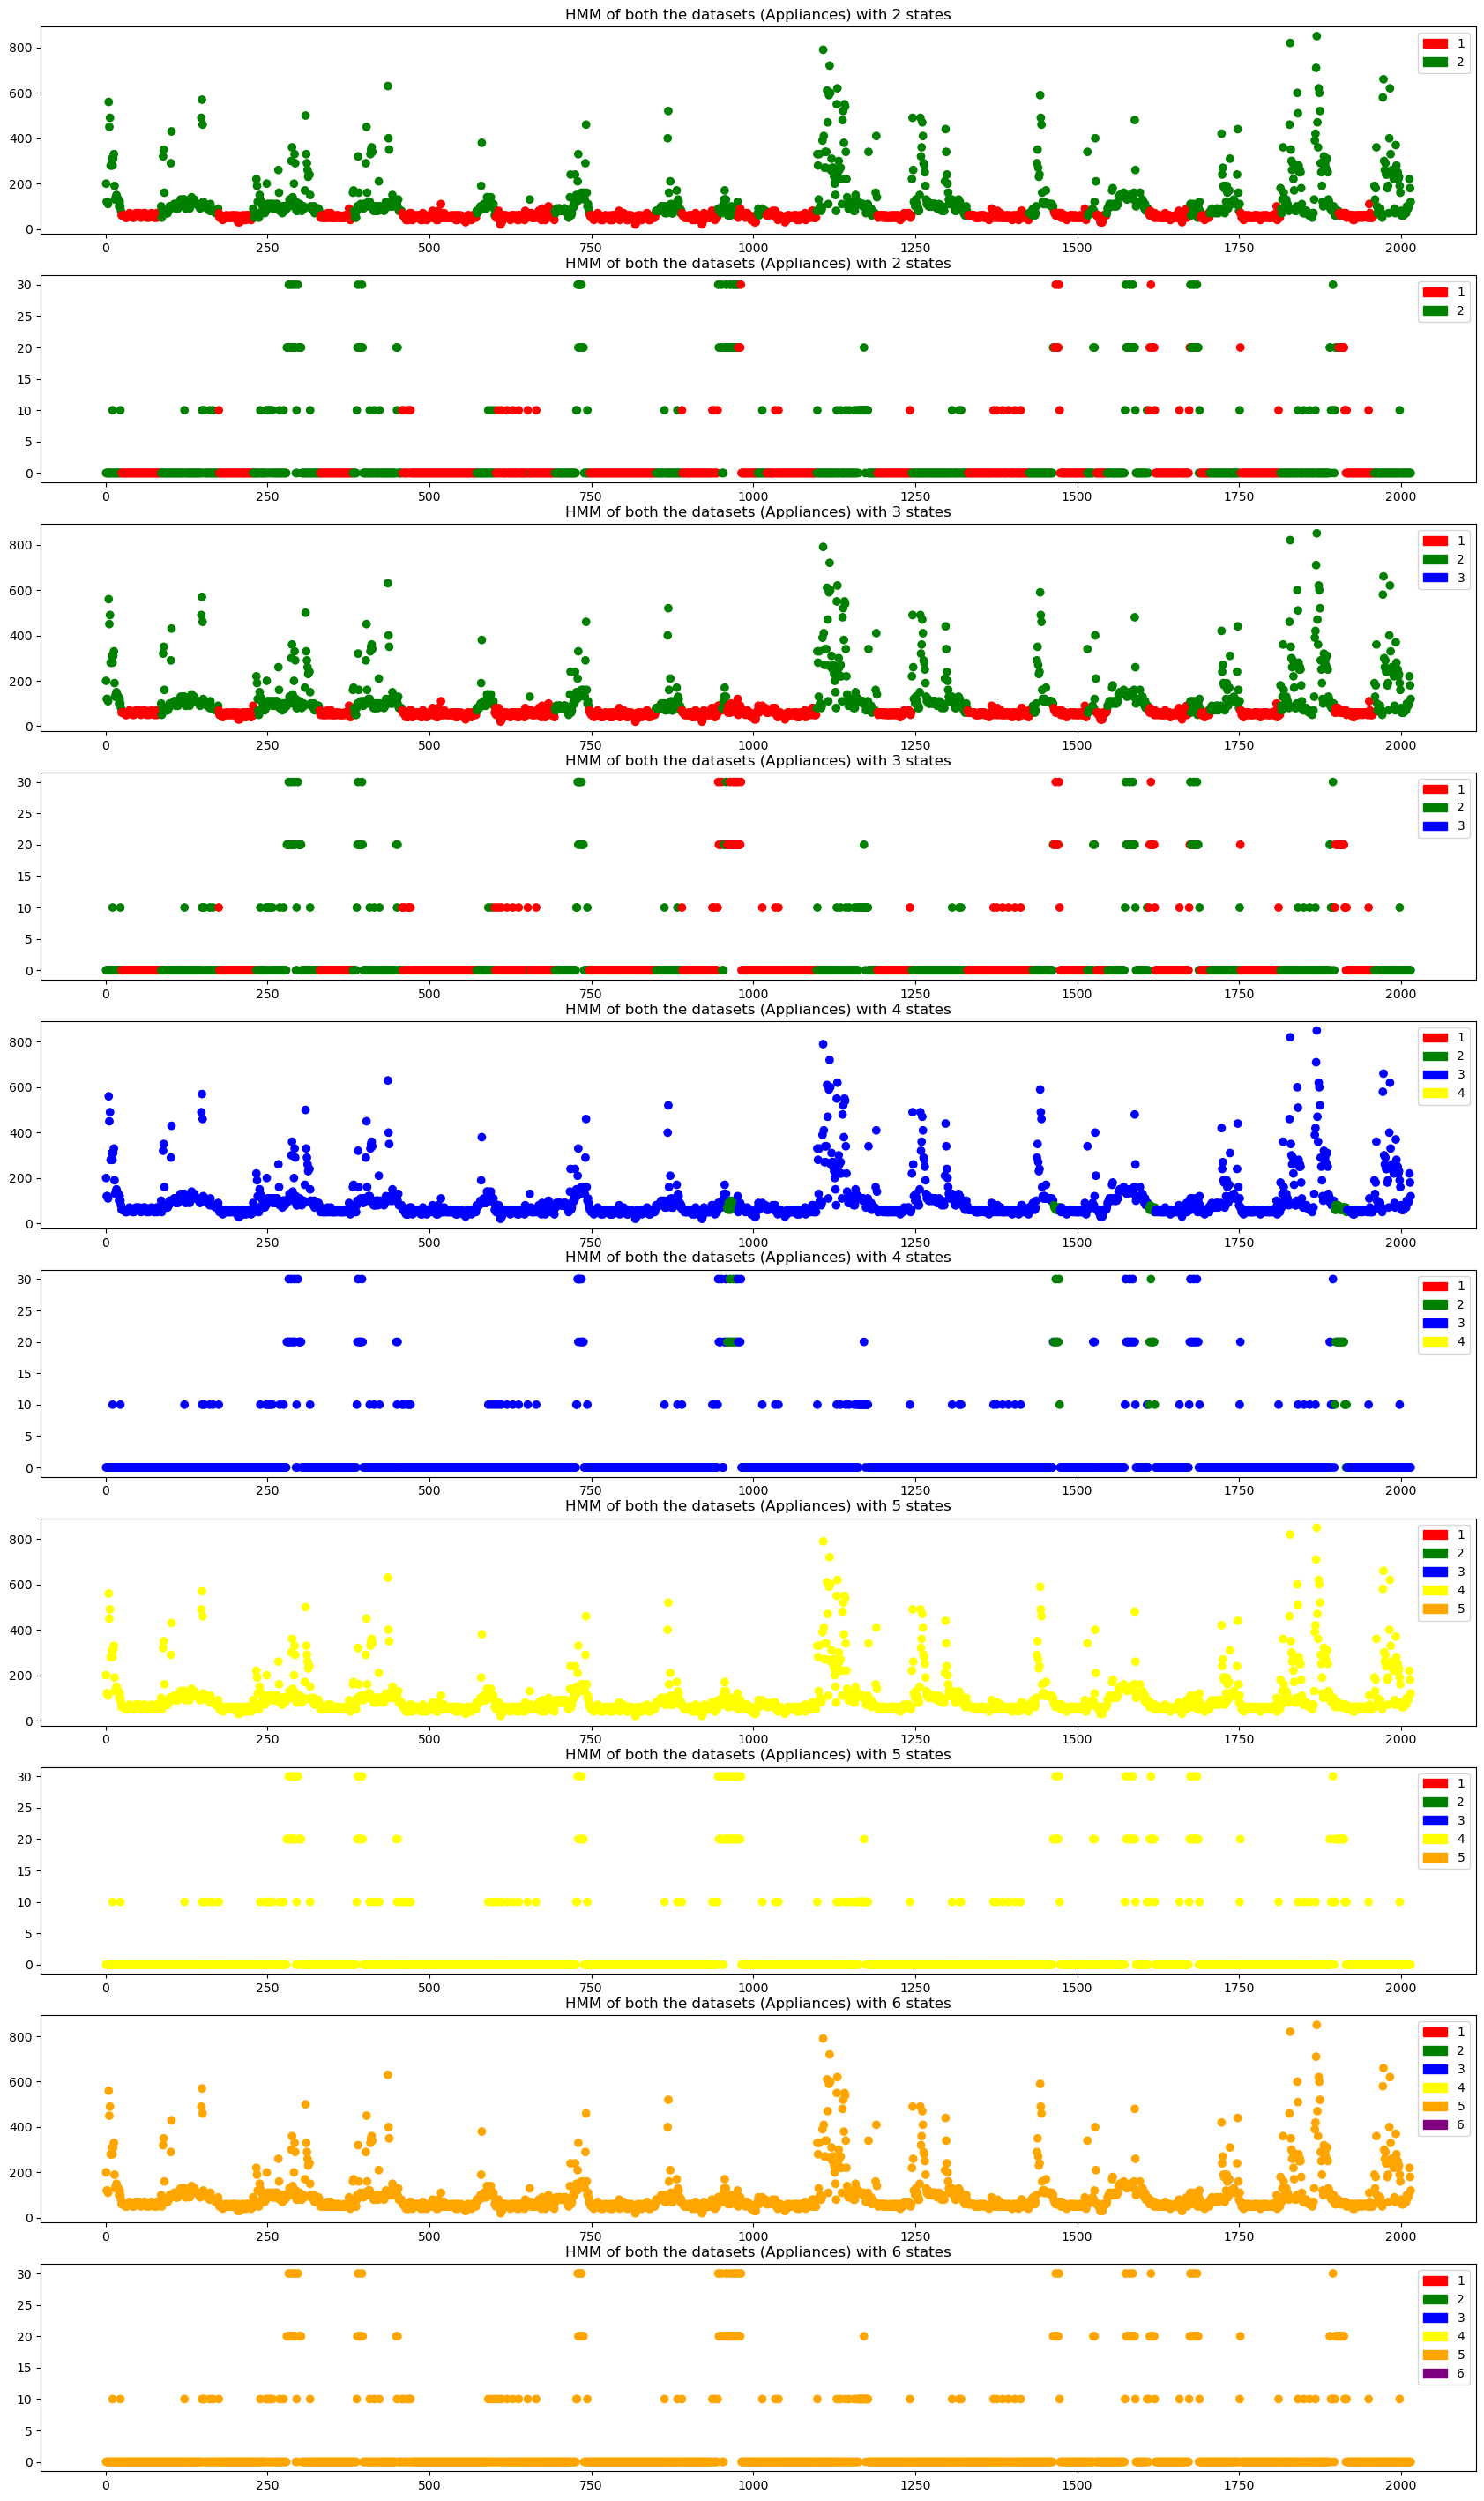

In [486]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig3, ax3 = plt.subplots((MAX_STATES*2)-4, 1, figsize=(21,36))

max_range = Appliances_X['test'].shape[0]
# max_range = 100
for i in range(2, MAX_STATES):
    titleCA = 'HMM of both the datasets (Appliances) with {} states'.format(i)
    ax3[(i*2) - 4].set(title=titleCA)
    ax3[(i*2) - 4].scatter(y=Concatenated_X['test'][1:max_range, 0], color=colorsC[i][1:max_range], x=range(1, max_range))
    ax3[(i*2) - 4].legend(handles=red_patch[:i])
    
    titleCL = 'HMM of both the datasets (Ligths) with {} states'.format(i)
    ax3[(i*2) - 3].set(title=titleCL)
    ax3[(i*2) - 3].scatter(y=Concatenated_X['test'][1:max_range, 1], color=colorsC[i][1:max_range], x=range(1, max_range))
    ax3[(i*2) - 3].legend(handles=red_patch[:i])

### Comments on the viterbi decoded hidden states on the test set of both the Appliances and the Lights dataset

* We can clearly see that the hidden states are different only if less thant 4 states are used. After that the hidden states are very similar and the timeseries is monocromatic, meaning that the state is not changing over time. This is due to the fact that the number of states is too high and the model is not able to distinguish them.

## Let's compare the concatenated test with the Appliances and the Lights test

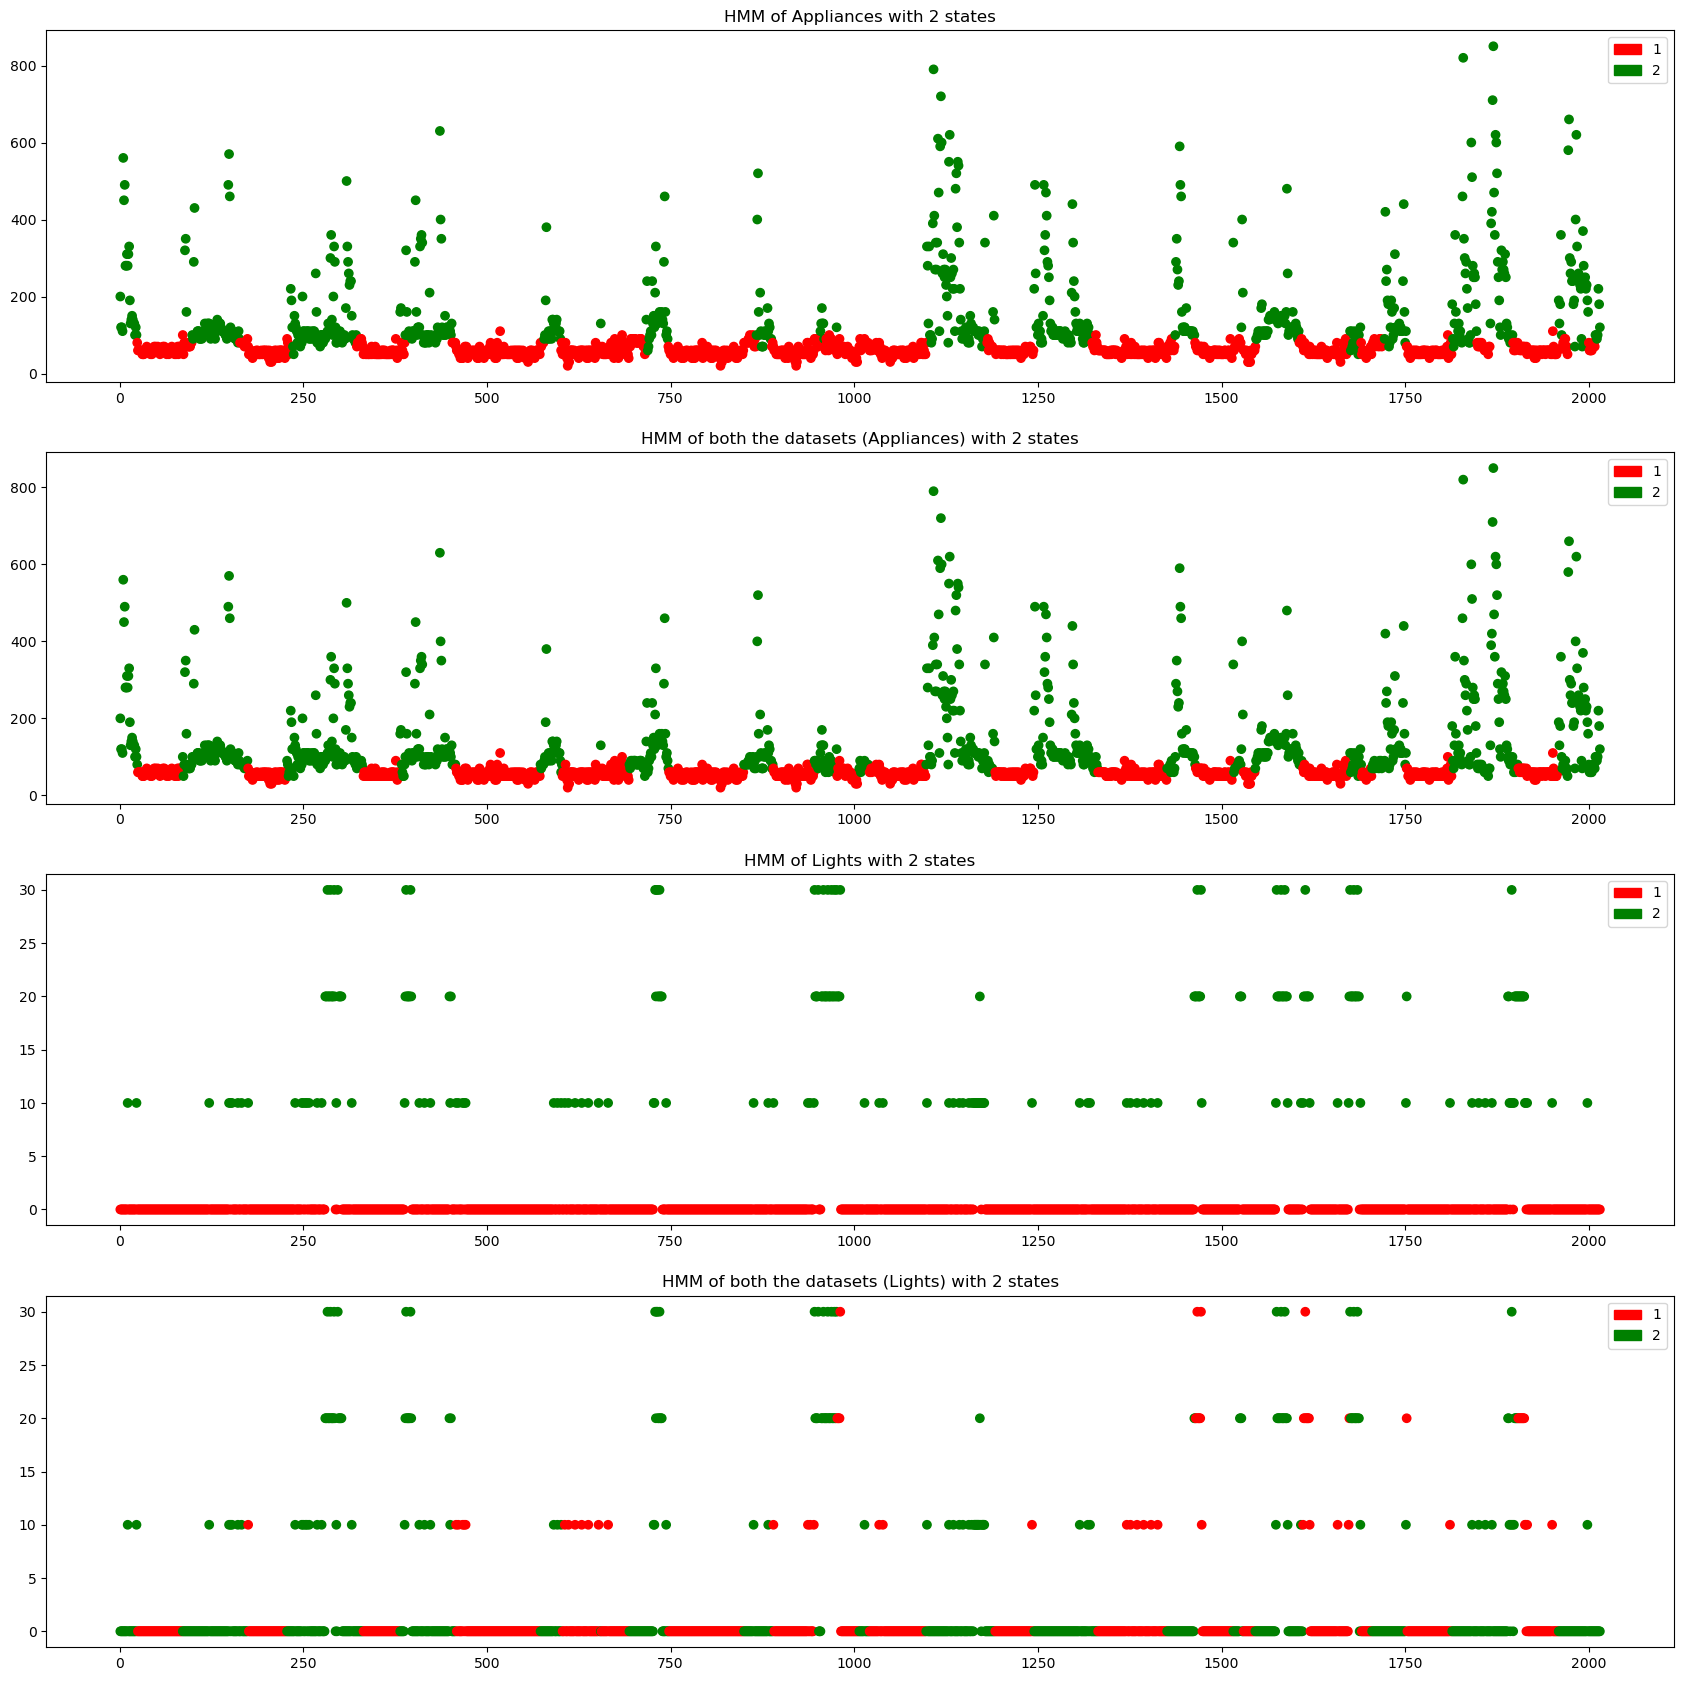

In [491]:
fig, ax4 = plt.subplots(4, 1, figsize=(21,21))

max_range = Appliances_X['test'].shape[0]
# max_range = 100

states = 2

titleA = 'HMM of Appliances with {} states'.format(states)
ax4[0].set(title=titleA)
ax4[0].scatter(y=Appliances_X['test'][1:max_range], color=colorsA[states][1:max_range], x=range(1, max_range))
ax4[0].legend(handles=red_patch[:states])

titleCA = 'HMM of both the datasets (Appliances) with {} states'.format(states)
ax4[1].set(title=titleCA)
ax4[1].scatter(y=Concatenated_X['test'][1:max_range, 0], color=colorsC[states][1:max_range], x=range(1, max_range))
ax4[1].legend(handles=red_patch[:states])

titleL = 'HMM of Lights with {} states'.format(states)
ax4[2].set(title=titleL)
ax4[2].scatter(y=Lights_X['test'][1:max_range], color=colorsL[states][1:max_range], x=range(1, max_range))
ax4[2].legend(handles=red_patch[:states])

titleCL = 'HMM of both the datasets (Lights) with {} states'.format(states)
ax4[3].set(title=titleCL)
ax4[3].scatter(y=Concatenated_X['test'][1:max_range, 1], color=colorsC[states][1:max_range], x=range(1, max_range))
ax4[3].legend(handles=red_patch[:states]);

## Comments on the concatenated test set

### We can see that the HMM model trained on the concatenated dataset is able to distinguish the hidden states, but it is not able to distinguish them as well as the models trained on the two datasets separately. 



<Axes: >

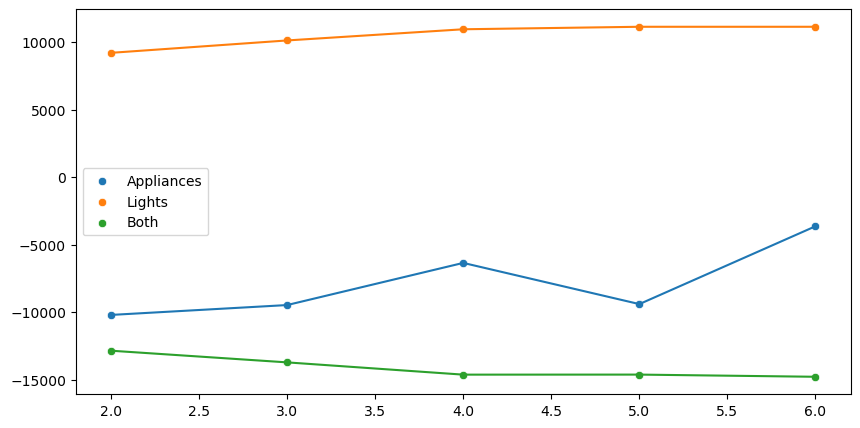

In [488]:
import seaborn as sns

fig2, ax2 = plt.subplots(1, 1, figsize=(10,5))

titleL = 'HMM log likelihood values'

sns.scatterplot(PAppTest, ax=ax2, label='Appliances')
sns.lineplot(PAppTest, ax=ax2)
sns.scatterplot(PLightsTest, ax=ax2, label='Lights')
sns.lineplot(PLightsTest, ax=ax2)
sns.scatterplot(PConcTest, ax=ax2, label='Both')
sns.lineplot(PConcTest, ax=ax2)

# Conclusion 

* We can see that the "best" model is the one trained on the Appliances dataset with 6 hidden states. This model is able to give a good likelihood on the validation set as well. The model trained on the Lights dataset has a strange behavior, it is able to distinguish the hidden states but it is not able to give a good likelihood (Actually it's positive :') ).
* The HMM trained on both the columns is not performing as well as the two models trained on the two columns separately. This could be due to the fact that the two columns are not independent, they are correlated (Not sure about that anyway).


This Notebook can be found on my github:
    - https://github.com/PaulMagosUni/ISPR/blob/main/Assignment2/Assignment2.ipynb